# Practical work #1

####Was done by Kolabin Y.V. 3822M1FIii1


In [202]:
%%capture
!pip install tqdm torchsummary

#### Importing the necessary libraries

In [203]:
import os
import matplotlib.pyplot as plot
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange
from torchsummary import summary
from sklearn.metrics import classification_report
from torch.utils.data import random_split
import time

#### Obtaining the path for saving the dataset

In [204]:
dir_name = os.getcwd()

#### CIFAR10 dataset downloading:

In [205]:
train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)

# Define the validation dataset size (20% of the original training dataset)
validation_size = int(0.2 * len(train_dataset))

# Split the original training dataset into training and validation datasets
train_dataset, validation_dataset = random_split(train_dataset, [len(train_dataset) - validation_size, validation_size])

test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


#### Let's recognize the shape of a train picture:

In [206]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

#### Function for displaying dataset images:


In [207]:
def show_images(images, title):

    # Specify the number of images to display (along the x and y axes)
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    # Size of an single image
    figsize = (10, 10)

    # Creating a figure grid
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)

    # Figure title
    fig.suptitle(title)

    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0) # Change the order (width, height, channels)
        ax.imshow(img)

#### Displaying one hundred train images:

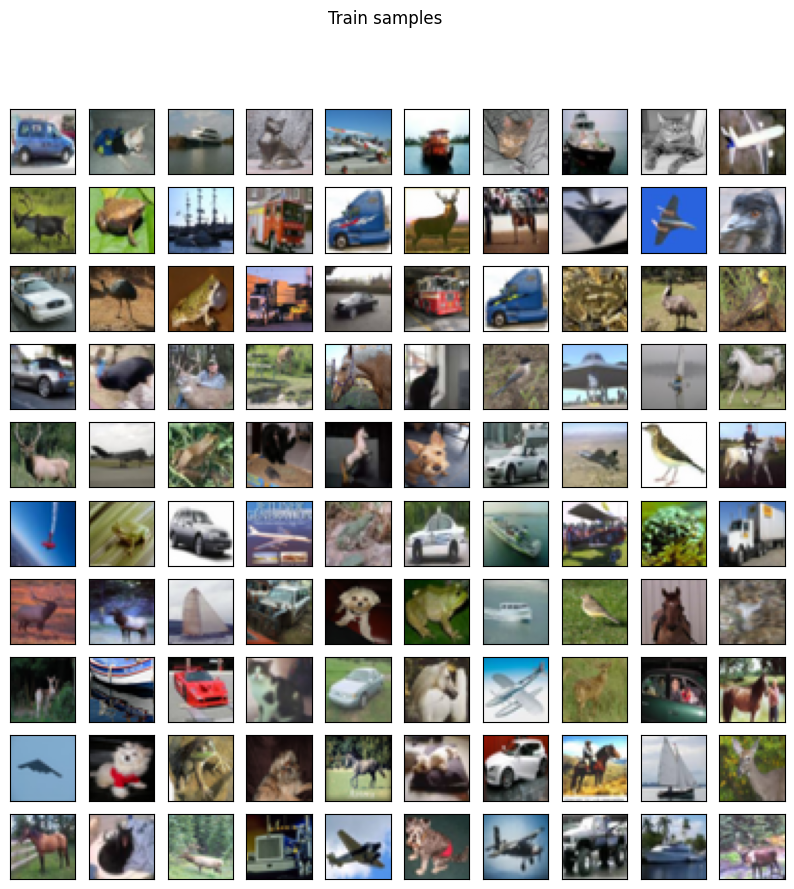

In [208]:
show_images(train_dataset, "Train samples")

#### Displaying one hundred test images:

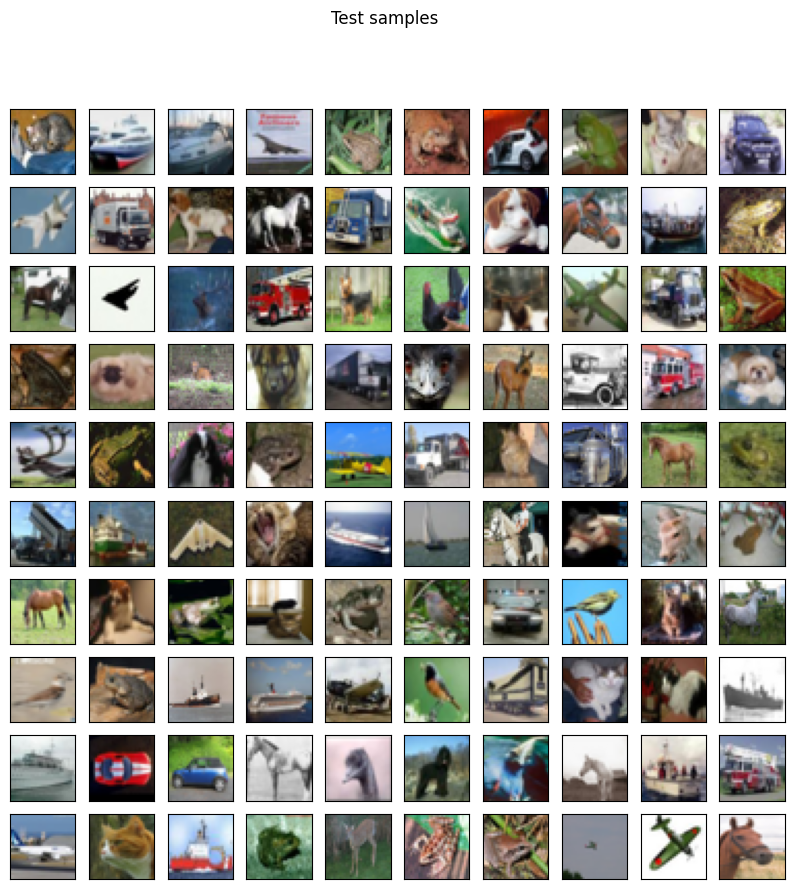

In [209]:
show_images(test_dataset, "Test samples")

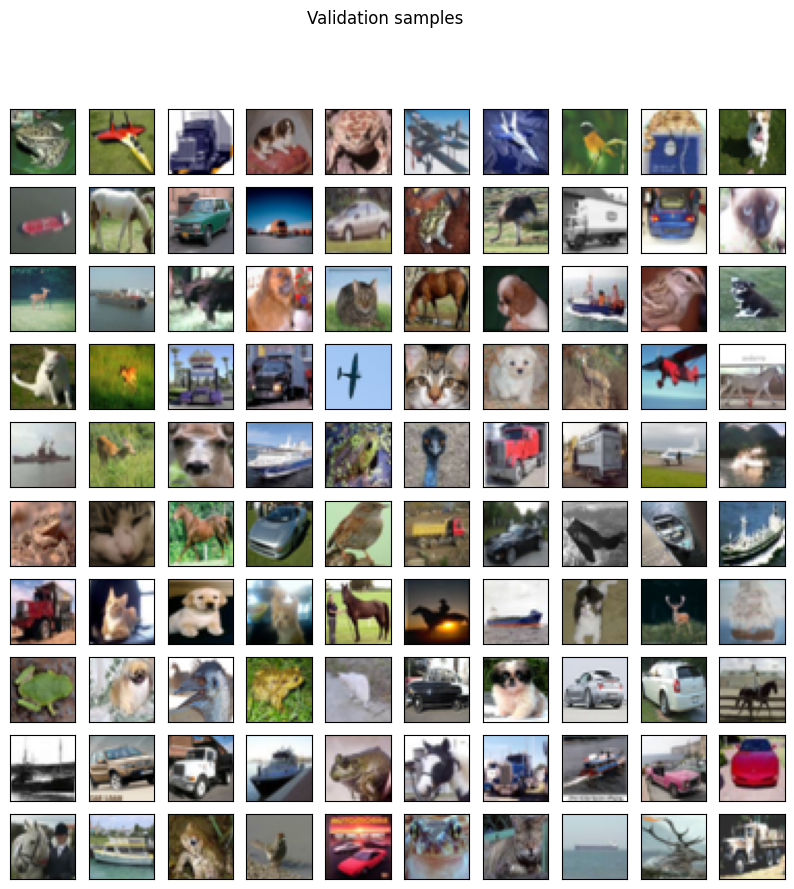

In [210]:
show_images(validation_dataset, "Validation samples")

#### Let's find out the number of training and testing samples

In [211]:
print("Number of train samples: {}".format(len(train_dataset)))

Number of train samples: 40000


In [212]:
print("Number of validation samples: {}".format(len(validation_dataset)))

Number of validation samples: 10000


In [213]:
print("Number of test dataset: {}".format(len(test_dataset)))

Number of test dataset: 10000


#### Prepearing data with DataLoader

While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [214]:
batch_size=32

In [215]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [216]:
validation_data_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=False
)

In [217]:
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

#### Creating the CNN class:

In [218]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()

        # Convolution. The size of the resulting feature map:
        # 32 x ((32 - 3 + 2*1)/1 + 1) x ((32 - 3 + 2*1)/1 + 1)
        # 32 x 32 x 32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Batch normalization:
        self.bn1 = nn.BatchNorm2d(32)

        # Activation function. The size of the resulting feature map:
        # 32 x 32 x 32
        self.relu = nn.ReLU()

        # Spatial max pooling. The size of the resulting feature map:
        # 32 x ((32 - 3)/2 + 1) x ((32 - 3)/2 + 1)
        # 32 x 15 x 15
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution. The size of the resulting feature map:
        # 64 x ((15 - 3 + 2*1)/1 + 1) x ((15 - 3 + 2*1)/1 + 1)
        # 64 x 16 x 16
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Batch normalization:
        self.bn2 = nn.BatchNorm2d(64)

        # Activation function. The size of the resulting feature map:
        # 64 x 16 x 16

        # Spatial max pooling. The size of the resulting feature map:
        # 64 x ((15 - 3)/2 + 1) x ((15 - 3)/2 + 1)
        # 64 x 8 x 8

        # Fully connected layer:
        self.fc1 = nn.Linear(64 * 8 * 8, 128)

        # Dropout:
        self.dropout = nn.Dropout(0.5)

        # Output fully connected layer:
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

cnn_model = ConvolutionalNeuralNetwork()

In [219]:
learning_rate = 0.03
num_epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr = learning_rate)

In [220]:
summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 128]         524,416
             ReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 545,290
Trainable params: 545,290
Non-trainable params: 0
-------------------------------

In [221]:
def training(model, criterion, optimizer, num_epochs, train_loader, validation_loader, max_grad_norm=2):
    start_full_time = time.time()

    for epoch in trange(num_epochs, leave=False):
        start_time = time.time()

        model.train()

        num_iter = 0
        for batch in train_loader:

            optimizer.zero_grad()

            input_data = batch[0].to(device)
            labels = batch[1].to(device)

            prediction = model(input_data)

            loss = criterion(prediction, labels)
            loss.backward()

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            num_iter += 1

        valid_loss = 0
        num_iter = 0

        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for batch in validation_loader:

                input_data = batch[0].to(device)
                labels = batch[1].to(device)

                prediction = model(input_data)

                loss = criterion(prediction, labels)

                valid_loss += loss.item()

                correct += (labels == prediction.argmax(dim=1)).sum().item()
                num_objs += len(labels)
                num_iter += 1

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {loss.item()}, Valid Loss: {valid_loss / num_iter}, Accuracy: {correct / num_objs}")
        print(f"Epoch time: {epoch_time:.2f} seconds")
    end_full_time = time.time()

    full_epoches_time = (end_full_time - start_full_time)/60

    print(f"Training time: {full_epoches_time:.2f} minutes")

In [222]:
def predict_and_report(model, data_loader, device, class_names, criterion):
    model.eval()
    true_labels = []
    predicted_labels = []
    test_loss = 0
    numt_iter = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, total=len(data_loader)):

            input_data = batch[0].to(device)
            labels = batch[1].to(device)

            prediction = model(input_data)
            _, predicted = torch.max(prediction, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

            loss = criterion(prediction, labels)
            test_loss += loss.item()

            numt_iter += 1

    test_loss /= numt_iter
    print("Test loss: ", test_loss)
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    return report

In [223]:
training(cnn_model, loss_function, optimizer, num_epochs, train_data_loader, validation_data_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20]
Train Loss: 1.6540879011154175, Valid Loss: 1.9205781472757602, Accuracy: 0.3425
Epoch time: 10.76 seconds
Epoch [2/20]
Train Loss: 1.2337943315505981, Valid Loss: 1.130031818018173, Accuracy: 0.6019
Epoch time: 14.95 seconds
Epoch [3/20]
Train Loss: 1.0263683795928955, Valid Loss: 1.1140796220340667, Accuracy: 0.6098
Epoch time: 14.96 seconds
Epoch [4/20]
Train Loss: 1.1334372758865356, Valid Loss: 1.2146705998399387, Accuracy: 0.5655
Epoch time: 10.44 seconds
Epoch [5/20]
Train Loss: 0.9346128106117249, Valid Loss: 0.9763575546657697, Accuracy: 0.6508
Epoch time: 10.47 seconds
Epoch [6/20]
Train Loss: 0.8560285568237305, Valid Loss: 1.0325382900314208, Accuracy: 0.6314
Epoch time: 10.54 seconds
Epoch [7/20]
Train Loss: 0.8963153958320618, Valid Loss: 0.9188362203847867, Accuracy: 0.671
Epoch time: 10.54 seconds
Epoch [8/20]
Train Loss: 0.8117645382881165, Valid Loss: 0.8618645103404317, Accuracy: 0.6977
Epoch time: 10.42 seconds
Epoch [9/20]
Train Loss: 0.874641180038452

In [224]:
%%capture
cnn_model.to('cpu')

In [225]:
loss_function = torch.nn.CrossEntropyLoss()

In [226]:
report = predict_and_report(cnn_model, test_data_loader, 'cpu', ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9'], loss_function)


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss:  0.7619152110986436


In [227]:
print(report)

              precision    recall  f1-score   support

     class_0       0.74      0.79      0.77      1000
     class_1       0.81      0.87      0.84      1000
     class_2       0.66      0.63      0.64      1000
     class_3       0.59      0.53      0.56      1000
     class_4       0.67      0.72      0.70      1000
     class_5       0.69      0.62      0.65      1000
     class_6       0.84      0.76      0.80      1000
     class_7       0.73      0.84      0.78      1000
     class_8       0.82      0.85      0.83      1000
     class_9       0.82      0.79      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

